<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Animation_for_a_deep_water_wave.gif" alt="Animation for a deep water wave" />
</p>

# Wave Height from Buoy 44013

---

## Overview
Generating a wavelet power spectrum from the time-series data [from wave heights from buoy station 44013]((https://www.ndbc.noaa.gov/station_history.php?station=44013)) east of Boston
1. Prerequisties
2. Background
3. Download and Organize Buoy Data
4. Wavelet Input Values
5. PyWavelets
6. Power Spectrum

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Used to plot data |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Used to work with large arrays |
| [Intro to Datetimes](https://foundations.projectpythia.org/core/datetime.html) | Helpful | Useful to understand strings vs. datetimes |

- **Time to learn**: 35 minutes

---

## Background

Buoys float on the surface of water, and while they can serve many purposes, research facilities like NOAA's [National Data Buoy Center](https://www.ndbc.noaa.gov/) provide real-time and historical data about waves and climate on the ocean and within lakes from hundreds of buoys around the world.

![buoy-world-map](https://github.com/user-attachments/assets/4d93cc9c-3e1a-47d9-a321-87e53a831813)


Each buoy has been in service for a variety of years and collects different information. [Buoy 44013](https://www.ndbc.noaa.gov/station_page.php?station=44013) is off the coast of Boston in the Massachusetts Bay and reports information about the wind speed and direction, atmospheric pressure, air temperature, dew point, water temperature, and wave height throughout the year.

| Location | Buoy |
| --- | --- |
| ![buoy-station](https://github.com/user-attachments/assets/aaa73336-28d7-450e-b47f-6a8cc36188fb) | ![buoy-example](https://www.ndbc.noaa.gov/images/stations/2_1m_ionomer_foam_mini.jpg) |


44013 is owned and operated by the National Data Buoy Center and measures a depth of 64.6 meters and has a watch circle radius of 122 yards, with standard meterological data dating back to 1984.

Example Buoy Camera Photos from March 24, 2025:

![buoy-camera](https://www.ndbc.noaa.gov/images/buoycam/Z03A_2025_03_24_1710.jpg)

For thie notebook, we will be investigating the wave height of the buoy across two years in the early 2000's

## Imports

In [3]:
import numpy as np                          # working with arrays
import matplotlib.pyplot as plt             # plot data
import datetime                             # converting strings to datetime objects
import requests                             # retrieve data from text on a website

import pywt                                 # PyWavelets

## Access Buoy Data

First, we will need to download the relevant data we need from NOAA National Data Buoy Center. For this notebook, we will be investigating wave height buoy data from 2001 to 2002.

The buoy contains more information than just wave height, so we will need to only save data relevant to the date and time and the wave height. So, the only columns we need to keep are (`YY`, `MM`, `DD`, `hh`) and wave height (`WVHT`)

We will iterate through the years and save and concantate the data into a single large array.

In [7]:
years = [2001, 2002]
date_times = np.array([])
wave_height = np.array([])
for i, year in enumerate(years):

    # collect data from NOAA Buoy link
    data_link = f"https://www.ndbc.noaa.gov/view_text_file.php?filename=41001h{year}.txt.gz&dir=data/historical/stdmet/"
    data_req = requests.get(data_link)
    data_txt = data_req.text
    data = np.genfromtxt(data_txt.splitlines(), comments=None, dtype='str')

    # Find the index for datetime and wave height information
    datetime_index = np.where(data[0] == "hh")[0][0]
    wave_height_index = np.where(data[0] == "WVHT")[0][0]
    
    # collect data from all rows for the columns of datetime and wave height
    # [1:] skips the first row with header informaiton
    date_time = data[:,:datetime_index+1][1:]
    data_wave_height = data[:,wave_height_index][1:] 

    # Converts the string data collected from the source to a float
    data_wave_height = data_wave_height.astype(float)

    # Concatenate all data into a single array
    if i == 0:
        date_times = date_time
        wave_height = data_wave_height
    else:
        date_times = np.concatenate([date_times, date_time])
        wave_height = np.concatenate([wave_height, data_wave_height])

## Clean Up Wave Height data

Buoy stores null data as 99.00, so we will replace 99.00 with nan

In [8]:
print(f"Max wave hieght before applying nan = {max(wave_height)} m")
wave_height = np.where(wave_height == 99.00, np.nan, wave_height)
print(f"Max wave hieght after applying nan  = {max(wave_height)} m")

Max wave hieght before applying nan = 99.0 m
Max wave hieght after applying nan  = 9.38 m


## Convert Time to Datetimes

Buoy stores datetime information as seperate columns of data with `YYYY` `MM` `DD` and `HH`. For Python to recognize these strings as a date, we need to combine the strings into a single datetime value.

In [10]:
dates = []
for date in date_times:
    # combine each seperate column into a single string: YYYYMMDDHH
    date_string = "".join(date)
    # convert string to a datetime object
    dates.append(datetime.datetime.strptime(date_string, "%Y%m%d%H"))
dates = np.array(dates)
print(f"First Date = {dates[0]}")
print(f"Last Date  = {dates[-1]}")

First Date = 2001-01-01 00:00:00
Last Date  = 2002-12-17 20:00:00


## Plot and View Data

Let's give the data a look!

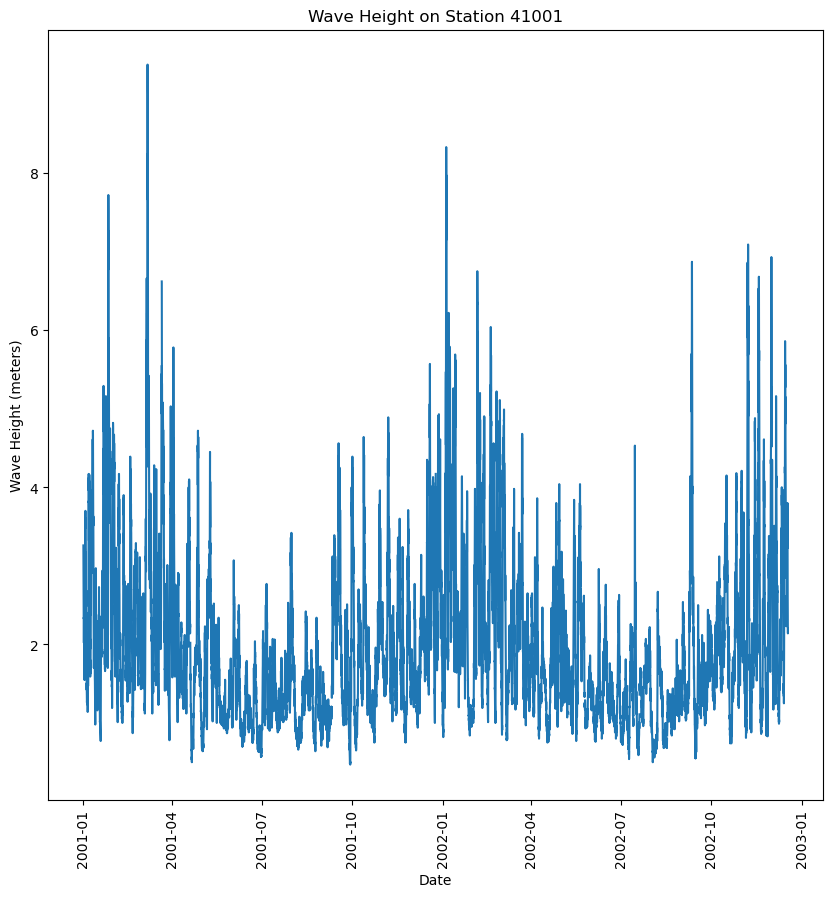

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Wave Height on Station 41001")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Wave Height (meters)")
plt.plot(dates, wave_height)
plt.show()

## Wavelet Input Values

Wavelet inputs include:

- x: Input time-series data (for example, the time and wave height of data)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

In [13]:
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 64  # largest scale

**For this example, we will be using a complex Morlet with a bandwidth of 1.5 and a center frequency of 1**

In [14]:
bandwidth = 1.5
center_freq = 1
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.5-1


## Applying Wavelets

In [17]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=wave_height, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)
#f = pywt.scale2frequency(wavelet_mother, scales)/dt
#print(f)

## Power Spectrum
The power spectrum is the real component of the wavelet coefficients. We can find this value by squaring the absolute value of the `wavelet_coeffs` to return the magnitude of the real component to make a better graph.

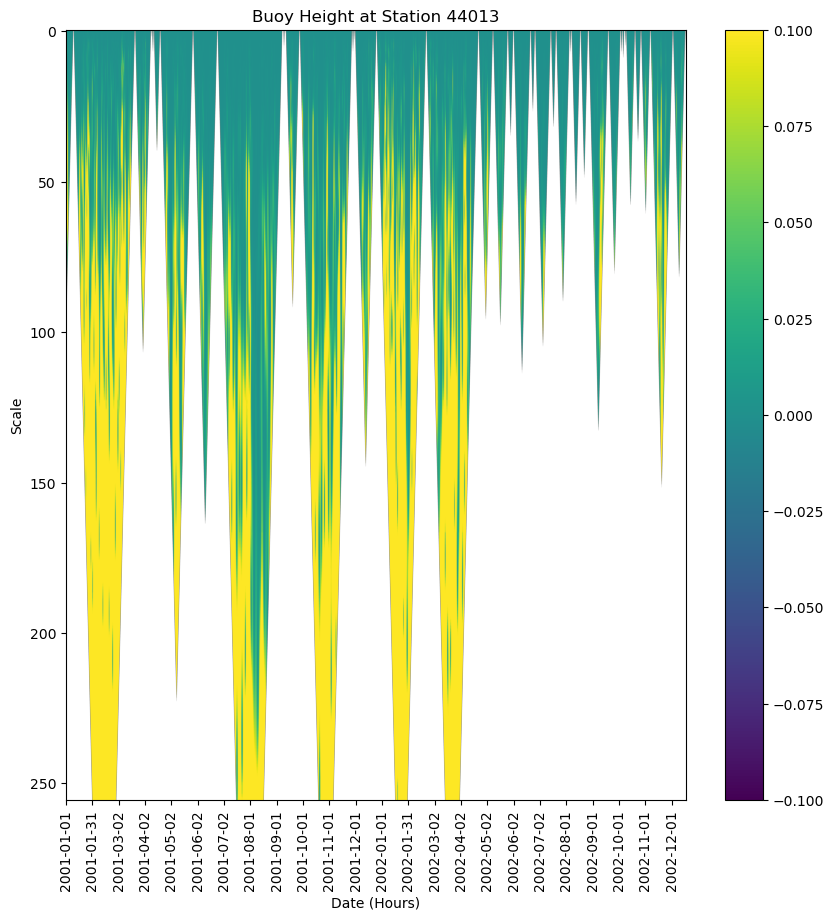

In [18]:
power = np.power((abs(wavelet_coeffs)), 2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

num = 730 # hours in a month
x_ticks = range(0, len(dates), num)
x_ticklabels = []
for date in dates[::num]:
    x_ticklabels.append(str(date)[:-9])
plt.xticks(ticks=x_ticks, labels=x_ticklabels,rotation=90)

plt.title("Buoy Height at Station 44013")
plt.xlabel("Date (Hours)")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

## What Went Wrong?

The current wavelet has a lot of blank space. This is the result of the `nan` values. So, to get a complete wavelet, we should filter out the `nan` values before we apply a wavelet. We can do this by applying a mask and interpolating.

In [20]:
wave_len = np.arange(len(wave_height))
mask = np.isfinite(wave_height)
xfiltered = np.interp(wave_len, wave_len[mask], wave_height[mask])

Time to get our `wavelet_coeffs` from the newly filtered data

In [21]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=xfiltered, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)
#f = pywt.scale2frequency(wavelet_mother, scales)/dt
#print(f)

## Power Spectrum, Take Two

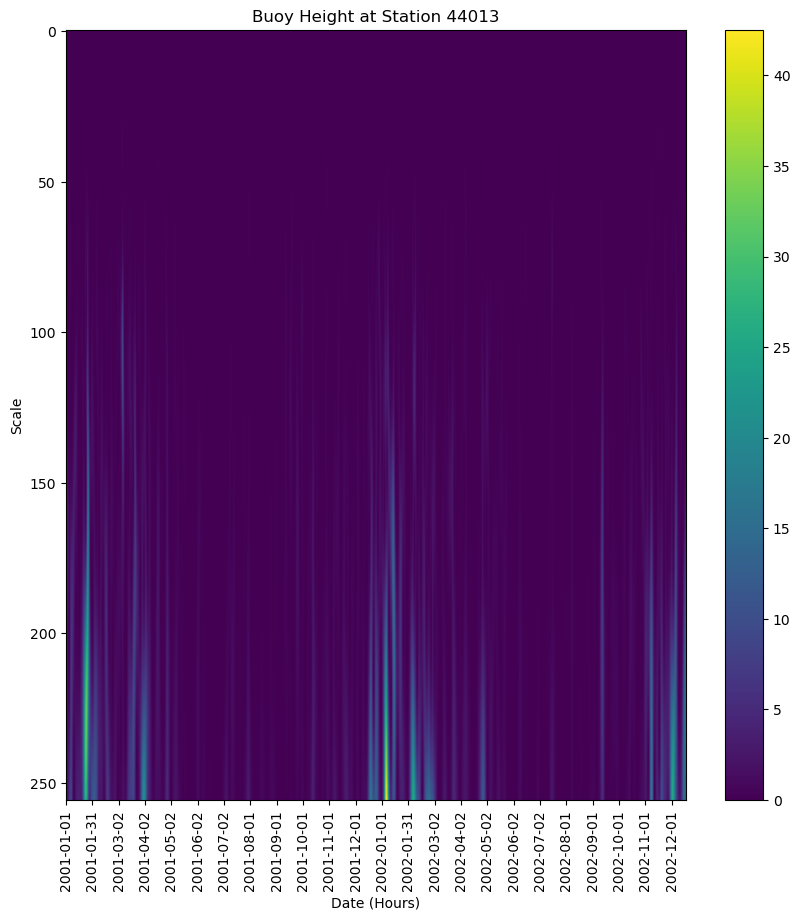

In [22]:
power = np.power((abs(wavelet_coeffs)), 2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

num = 730 # hours in a month
x_ticks = range(0, len(dates), num)
x_ticklabels = []
for date in dates[::num]:
    x_ticklabels.append(str(date)[:-9])
plt.xticks(ticks=x_ticks, labels=x_ticklabels,rotation=90)

plt.title("Buoy Height at Station 44013")
plt.xlabel("Date (Hours)")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

## Conclusions

The power spectrum above demonstrates a strong peak (in yellow) wihtin the first month of the year.

---

## Summary
TODO

### What's next?

- [Learn how more about PyWavelets](https://pywavelets.readthedocs.io/en/latest/regression/index.html)


## Resources and references

- ["A Practical Guide to Wavelet Analysis" (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)